# Comparison of trajectories

We want to compare the trajectories of the standard trained model and the robust trained model

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import numpy as np

# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
seed = np.random.randint(1,200)
# seed = 56
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
print(seed)
g = torch.Generator()
g.manual_seed(seed)

111



# Data preparation

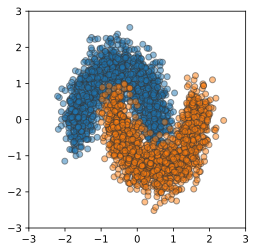

In [2]:
data_noise = 0.2
plotlim = [-3, 3]
subfolder = 'late_rob_moons'


from models.training import create_dataloader
dataloader, dataloader_viz = create_dataloader('moons', noise = data_noise, plotlim = plotlim, random_state = seed)


In [3]:
#We can now conveniently access the data from the dataloaders
for X_test, y_test in dataloader_viz:
    print(X_test[:10], y_test[:10])
    break
    

tensor([[-0.7191,  0.8450],
        [ 1.5897, -0.7178],
        [-1.6985,  0.9685],
        [ 0.1670, -0.8705],
        [ 1.6550,  0.1869],
        [-1.4495,  0.8217],
        [ 1.7920, -0.8686],
        [-0.7082,  2.0186],
        [ 0.6240, -0.2706],
        [-0.9973,  1.9624]]) tensor([0, 1, 0, 1, 1, 0, 1, 0, 0, 0])


## Model dynamics

In [4]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 
augment_dim = 0

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 15, 15 
bound = 0.
fp = False #this recent change made things not work anymore
cross_entropy = True
turnpike = False

non_linearity = 'tanh' #'relu' #
architecture = 'inside' #outside


## Training and generating level sets

In [5]:

num_epochs = 60 #number of optimization runs in which the dataset is used for gradient decent
eps = 0.35

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
anode = NeuralODE(device, data_dim, hidden_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3) 

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
rnode = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_rnode = torch.optim.Adam(rnode.parameters(), lr=1e-3) 

In [6]:
from models.training import doublebackTrainer

trainer_anode = doublebackTrainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = 0) 
trainer_anode.train(dataloader, num_epochs)


Iteration 0/45
Loss: 0.873
Robust Term Loss: 0.000
Accuracy: 0.531

Iteration 10/45
Loss: 0.730
Robust Term Loss: 0.000
Accuracy: 0.641

Iteration 20/45
Loss: 0.720
Robust Term Loss: 0.000
Accuracy: 0.594

Iteration 30/45
Loss: 0.782
Robust Term Loss: 0.000
Accuracy: 0.531

Iteration 40/45
Loss: 0.681
Robust Term Loss: 0.000
Accuracy: 0.516
Epoch 1: 0.752

Iteration 0/45
Loss: 0.698
Robust Term Loss: 0.000
Accuracy: 0.469

Iteration 10/45
Loss: 0.686
Robust Term Loss: 0.000
Accuracy: 0.422

Iteration 20/45
Loss: 0.687
Robust Term Loss: 0.000
Accuracy: 0.469

Iteration 30/45
Loss: 0.595
Robust Term Loss: 0.000
Accuracy: 0.531

Iteration 40/45
Loss: 0.593
Robust Term Loss: 0.000
Accuracy: 0.578
Epoch 2: 0.633

Iteration 0/45
Loss: 0.577
Robust Term Loss: 0.000
Accuracy: 0.609

Iteration 10/45
Loss: 0.569
Robust Term Loss: 0.000
Accuracy: 0.562

Iteration 20/45
Loss: 0.598
Robust Term Loss: 0.000
Accuracy: 0.609

Iteration 30/45
Loss: 0.551
Robust Term Loss: 0.000
Accuracy: 0.594

Iterat

In [7]:
   
w = anode.linear_layer.weight
b = anode.linear_layer.bias

print(w)
print(b)

rnode.linear_layer.weight = w
rnode.linear_layer.bias = b

rnode.linear_layer.requires_grad =  False

Parameter containing:
tensor([[-0.8166,  0.2280],
        [ 0.9126,  0.6191]], requires_grad=True)
Parameter containing:
tensor([-0.0028, -0.2886], requires_grad=True)


In [8]:
trainer_rnode = doublebackTrainer(rnode, optimizer_rnode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = eps) 
trainer_rnode.train(dataloader, num_epochs)


Iteration 0/45
Loss: 0.879
Robust Term Loss: 0.428
Accuracy: 0.516

Iteration 10/45
Loss: 0.974
Robust Term Loss: 0.459
Accuracy: 0.500

Iteration 20/45
Loss: 0.759
Robust Term Loss: 0.318
Accuracy: 0.578

Iteration 30/45
Loss: 0.670
Robust Term Loss: 0.280
Accuracy: 0.672

Iteration 40/45
Loss: 0.619
Robust Term Loss: 0.236
Accuracy: 0.656
Epoch 1: 0.797

Iteration 0/45
Loss: 0.734
Robust Term Loss: 0.288
Accuracy: 0.500

Iteration 10/45
Loss: 0.702
Robust Term Loss: 0.249
Accuracy: 0.516

Iteration 20/45
Loss: 0.563
Robust Term Loss: 0.181
Accuracy: 0.594

Iteration 30/45
Loss: 0.587
Robust Term Loss: 0.186
Accuracy: 0.531

Iteration 40/45
Loss: 0.510
Robust Term Loss: 0.174
Accuracy: 0.703
Epoch 2: 0.608

Iteration 0/45
Loss: 0.604
Robust Term Loss: 0.196
Accuracy: 0.531

Iteration 10/45
Loss: 0.576
Robust Term Loss: 0.183
Accuracy: 0.594

Iteration 20/45
Loss: 0.541
Robust Term Loss: 0.154
Accuracy: 0.562

Iteration 30/45
Loss: 0.520
Robust Term Loss: 0.178
Accuracy: 0.641

Iterat

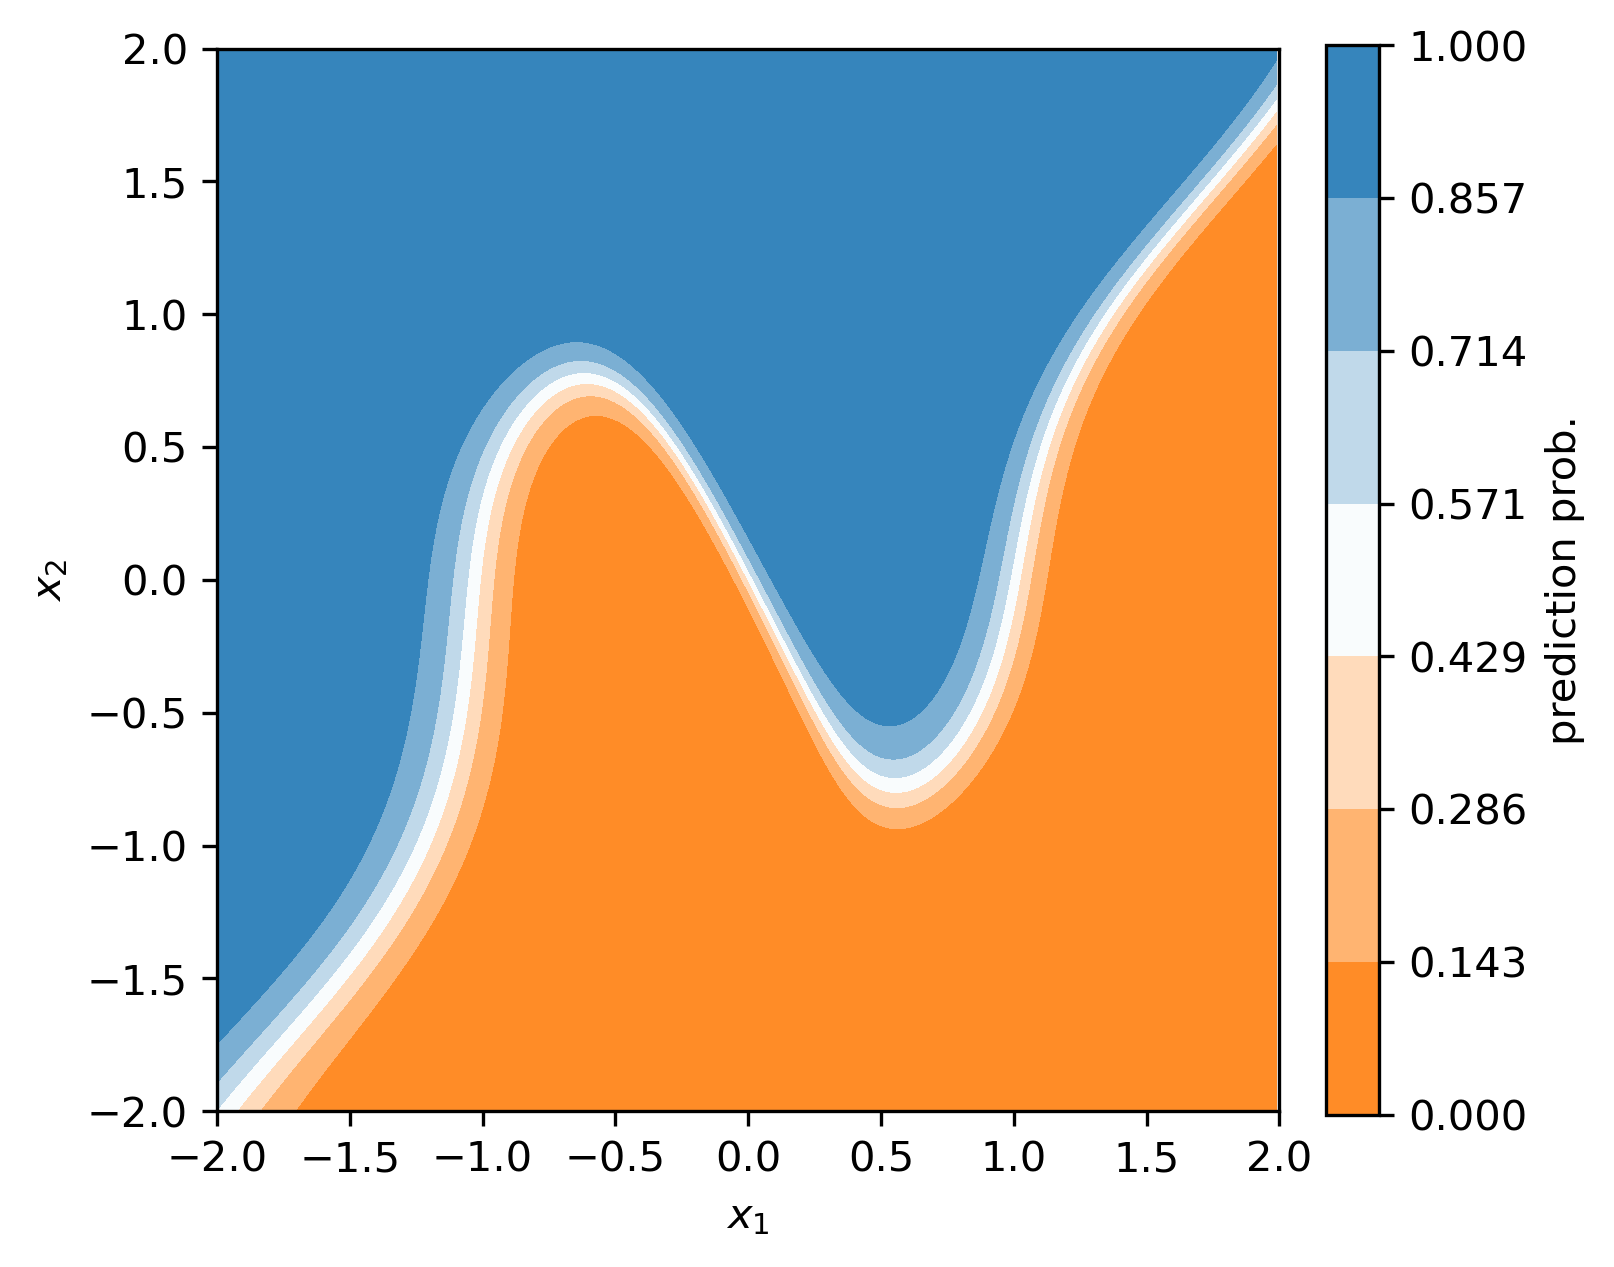

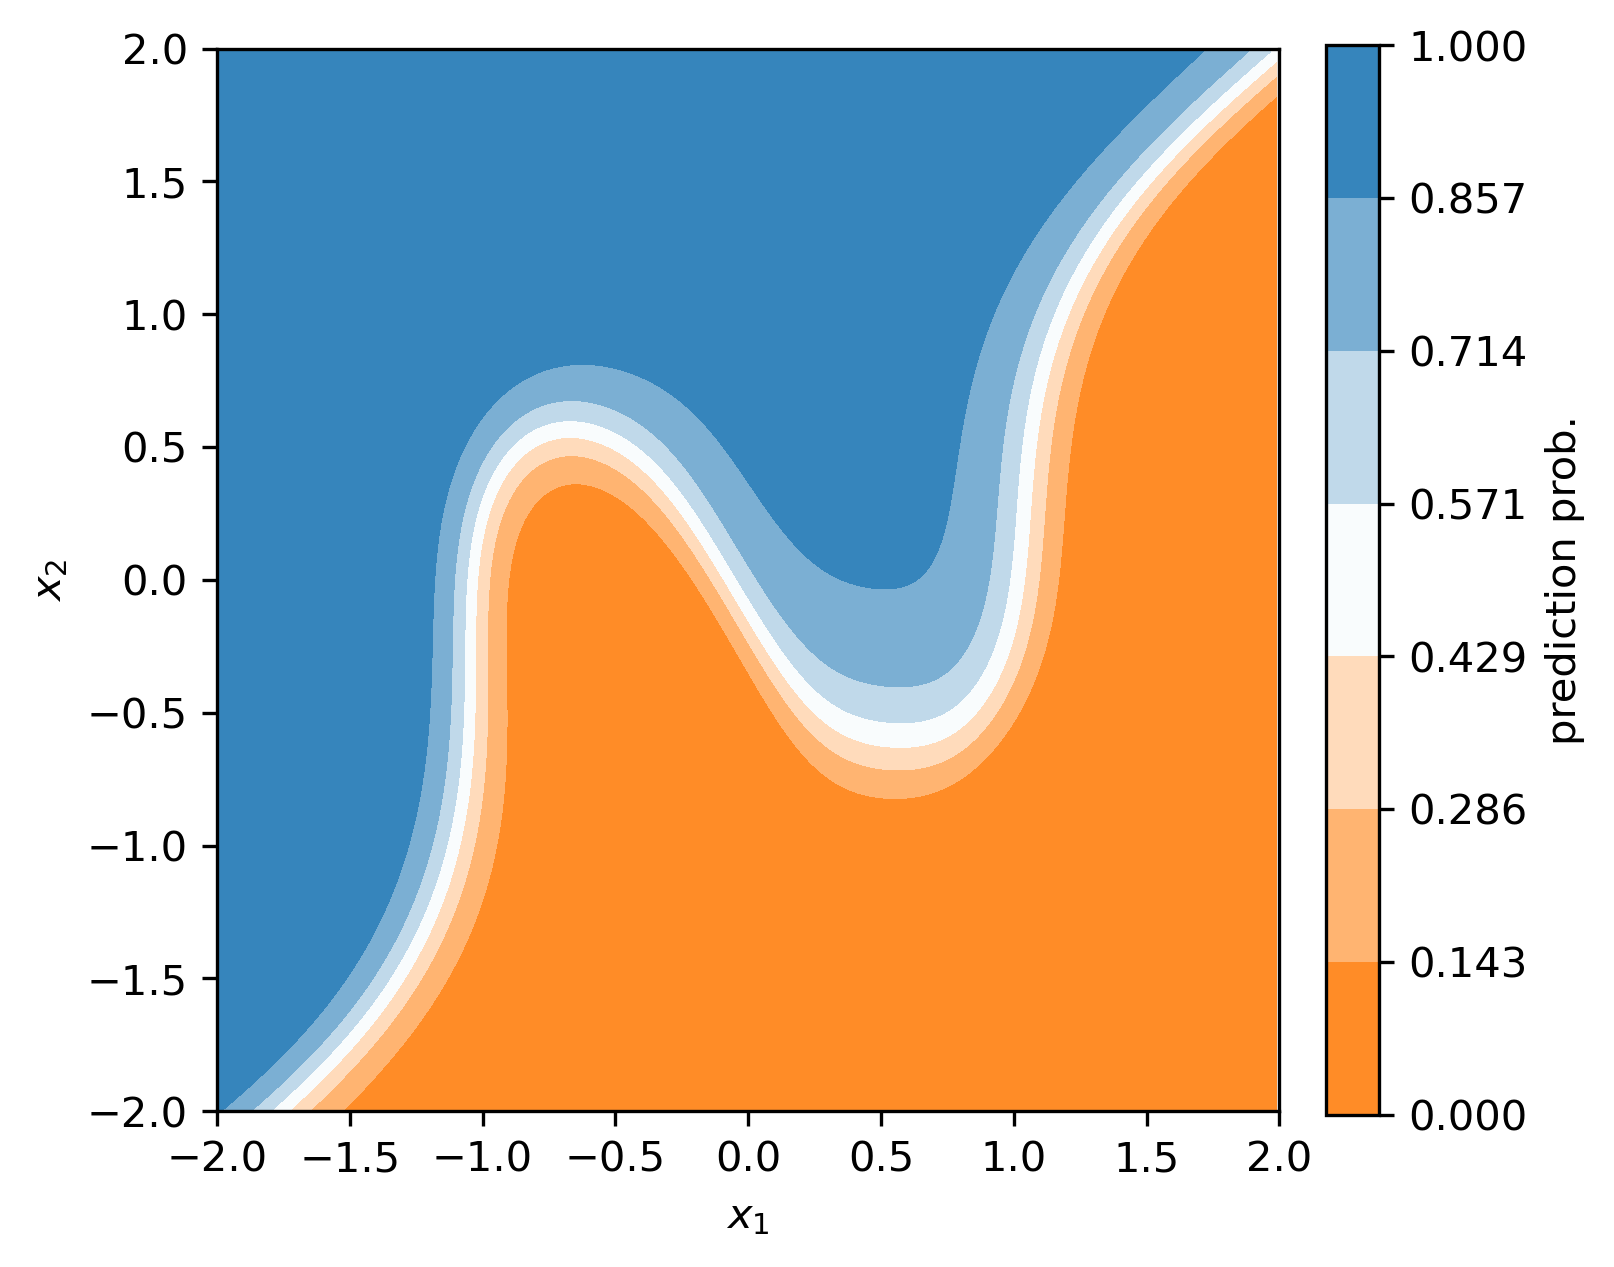

In [9]:
from plots.plots import classification_levelsets
import os

if not os.path.exists(subfolder):
        os.makedirs(subfolder)
        
fig_name_base = os.path.join(subfolder, 'levelsets')
classification_levelsets(anode, fig_name_base)
classification_levelsets(rnode, fig_name_base + '_rob')
from IPython.display import Image
img1 = Image(filename = fig_name_base + '.png', width = 400)
img2 = Image(filename = fig_name_base + '_rob.png', width = 400)

display(img1,img2)

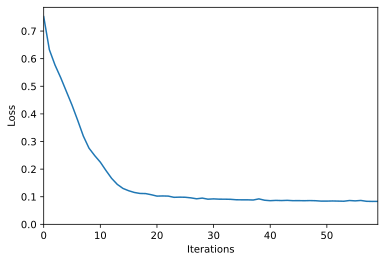

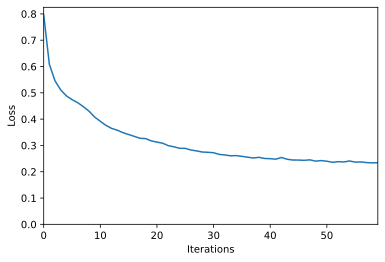

In [10]:
plt.plot(trainer_anode.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_anode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

plt.plot(trainer_rnode.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_rnode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

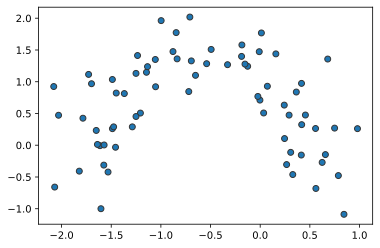

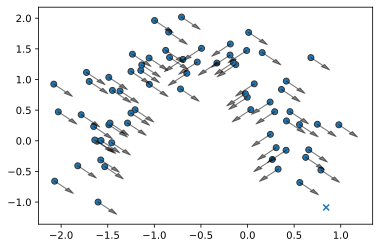

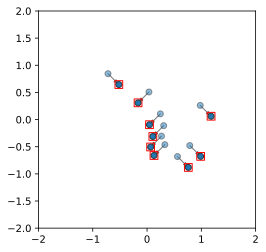

tensor(1)
label problem
tensor(1)
label problem
tensor(1)
label problem
tensor(1)
label problem
tensor(1)
label problem
tensor(1)
label problem
tensor(1)
label problem
tensor(1)
label problem
tensor(1)
label problem


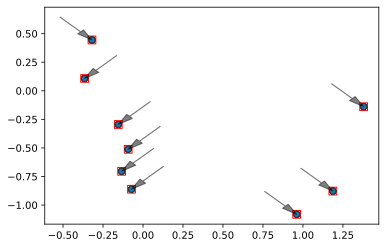

In [18]:
from numpy import arange
from torch import nn
from models.neural_odes import grad_loss_inputs

data_iter = iter(dataloader_viz)
X_viz, y_viz = next(data_iter)

# print(X_viz)

data_0 = X_viz[y_viz == 0]
data_1 = X_viz[y_viz == 1]

#Plot of the blue data points
plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333") 
# plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333")
plt.show()

#Check if the points are classified correctly by the classifier
m = nn.Softmax(dim = 1)
preds_0, _ = anode(data_0)
preds_0 = m(preds_0)
preds_0 = preds_0[:,0]

indices_0_corr_class = preds_0 > 0.5
indices_0_wrong_class = preds_0 < 0.5

# data_1_corr = data_1[preds_1 < 0.5]
# data_1_wrong = data_1[preds_1 >= 0.5]
# print(f'{data_0_corr = }')

data_0_corr = data_0[indices_0_corr_class]
data_0_wrong = data_0[indices_0_wrong_class]

# print(data_0_corr)
plt.scatter(data_0_corr[:, 0], data_0_corr[:, 1], edgecolor="#333") 
# plt.scatter(data_1_corr[:, 0], data_1_corr[:, 1], edgecolor="#333")
plt.scatter(data_0_wrong[:, 0], data_0_wrong[:, 1], color = 'C0', marker = 'x') 
# plt.scatter(data_1_wrong[:, 0], data_1_wrong[:, 1], color = 'C1', marker = 'x')


adversarial_budget = 0.2

grad_0 = grad_loss_inputs(anode, data_0_corr, torch.zeros(len(data_0_corr[:,0]), dtype = torch.int64), trainer_anode.loss_func)
grad_0 = adversarial_budget * torch.sgn(grad_0)
# grad_1 = grad_loss_inputs(data_1_corr)
for i in range(len(data_0_corr[:, 0])):
            plt.arrow(data_0_corr[i, 0], data_0_corr[i, 1], grad_0[i, 0], grad_0[i, 1],
                    head_width=0.05, head_length=0.1, fc='k', ec='k', alpha=0.5, length_includes_head = True)
plt.show()





#perturbing points and showing missclassification
data_0_attacks = data_0_corr + grad_0

preds_0_attacks, _ = anode(data_0_attacks)
preds_0_attacks = m(preds_0_attacks)
preds_0_attacks = preds_0_attacks[:,0]

indices_successful_attacks = preds_0_attacks <= 0.5
#successful attacks
data_0_attacks_success = data_0_attacks[indices_successful_attacks]
data_0_attacks_base = data_0_corr[indices_successful_attacks]

# data_0_wrong = data_0[preds_0 <= 0.5]

plt.scatter(data_0_attacks_base[:, 0], data_0_attacks_base[:, 1], edgecolor="#333", color = 'C0', alpha = 0.5)
plt.scatter(data_0_attacks_success[:, 0], data_0_attacks_success[:, 1], facecolor = 'none', s = 60, marker = 's', edgecolor="red")
plt.scatter(data_0_attacks_success[:, 0], data_0_attacks_success[:, 1], edgecolor="#333", color = 'C0')


grad_0_attacks = adversarial_budget * torch.sgn(grad_0[indices_successful_attacks])

data_0 = data_0_attacks_base
grad_0 = grad_0_attacks
# grad_1 = grad_loss_inputs(data_1_corr)
for i in range(len(data_0[:, 0])):
            plt.arrow(data_0[i, 0], data_0[i, 1], grad_0[i, 0], grad_0[i, 1],
                    head_width=0.05, head_length=0.1, fc='k', ec='k', alpha=0.5, length_includes_head = True, zorder = -1)
# plt.scatter(data_0_wrong[:, 0], data_0_wrong[:, 1], edgecolor="#333", color = 'C0')
# plt.scatter(data_0_wrong[:, 0], data_0_wrong[:, 1], facecolor = 'none', s = 60, marker = 's', edgecolor="red")
ax = plt.gca()
ax.set_aspect('equal')
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.show()

from models.neural_odes import grad_loss_inputs



        


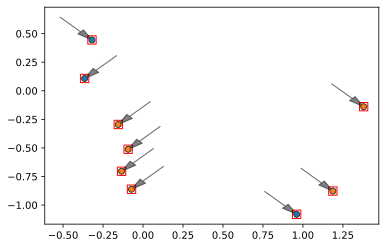

In [60]:
         
def viz_attack(points, labels, grad):
        """
        visualizes a given adversarial attack
        requires already drawn point samples and adds perturbation visuals
        
        input
        -points: the points that will be perturbed
        -labels: labels of all the points that are perturbed. 0 is blue, 1 is orange
        -grad: the perturbation directions for all points
        
        
        """
        labels = labels.detach().numpy()
        points = points.detach().numpy()
        grad = grad.detach().numpy()
        
        attacks = points + grad
        
        #plot the perturbed points
        plt.scatter(attacks[labels == 0, 0], attacks[labels == 0, 1], edgecolor="#333", color = 'C0', zorder = 3)
        plt.scatter(attacks[labels == 1, 0], attacks[labels == 1, 1], edgecolor="#333", color = 'C1', zorder = 3)

        #plot the gradient to the perturbed points
        for i in range(len(attacks[:, 0])):
                plt.arrow(points[i, 0], points[i, 1], grad[i, 0], grad[i, 1],
                        head_width=0.05, head_length=0.1, fc='k', ec='k', alpha=0.5, length_includes_head = True, zorder = 2)
        #mark the perturbed points with red square
        plt.scatter(attacks[:, 0], attacks[:, 1], facecolor = 'none', s = 70, marker = 's', edgecolor="red", zorder = 2)

#torch.zeros(len(data_0_attacks_success[:,0], dtype=int))
viz_attack(data_0_attacks_success, torch.tensor([0,0,0,1,1,1,1,1,1]) , grad_0)

In [75]:

def find_attacks(model,X,y, adversarial_budget, attack_type = 'fgsm'):
        """
        Takes point sample and finds successful attacks
        First filters out wrong classifications, then computes perturbations that are 
        """
        #check which points are correctly classified by model
        m = nn.Softmax(dim = 1)
        preds, _ = model(X)
        preds = m(preds)
        
        preds = preds[:,1]

        indices_corr_class = torch.abs(preds - y) < 0.5
        indices_wrong_class = torch.abs(preds - y) >= 0.5

        X_corr = X[indices_corr_class]
        X_wrong = X[indices_wrong_class]
        y_corr = y[indices_corr_class]
        y_wrong = y[indices_wrong_class]
        print('amount corr',len(X_corr))
        print('amount wrong',len(X_wrong))
        
        grad = grad_loss_inputs(model, X_corr, y_corr, trainer_anode.loss_func)
        if attack_type == 'fgsm':
                grad = torch.sgn(grad)
        if attack_type == 'l2':
                grad = torch.nn.functional.normalize(grad)
        grad = adversarial_budget * grad
        
        #successful attacks: perturb correctly classified points and check if the perturbed points are incorrectly classified
        X_attacks = X_corr + grad

        preds_attacks, _ = model(X_attacks)
        preds_attacks = m(preds_attacks)
        preds_attacks = preds_attacks[:,1]

        indices_successful_attacks = torch.abs(preds_attacks - y_corr) >= 0.5
        #successful attacks
        # X_attacks_success = X_attacks[indices_successful_attacks]
        X_attacks_base = X_corr[indices_successful_attacks]
        y_attacks = y_corr[indices_successful_attacks]
        grad = grad[indices_successful_attacks]
        print('amount succ attacks', len(X_attacks_base[:,0]))

        return X_attacks_base, y_attacks, grad

test = X_viz[y_viz == 1]
y_test = y_viz[y_viz == 1]

find_attacks(anode, test, y_test, 0.2)

amount corr 0
amount wrong 0
amount succ attacks 0


(tensor([], size=(0, 2)),
 tensor([], dtype=torch.int64),
 tensor([], size=(0, 2)))

In [74]:
test = X_viz[0:5]

print(test)

from torch.nn.functional import normalize

test = normalize(test)
print(test)
print(test.norm(dim = 1))


tensor([[-1.6134, -0.0071],
        [-1.2061,  0.5065],
        [-1.6508,  0.2329],
        [ 0.4553,  0.4756],
        [-1.8215, -0.4082]])
tensor([[-1.0000, -0.0044],
        [-0.9220,  0.3872],
        [-0.9902,  0.1397],
        [ 0.6915,  0.7224],
        [-0.9758, -0.2187]])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


amount corr 70
amount wrong 1
amount succ attacks 9


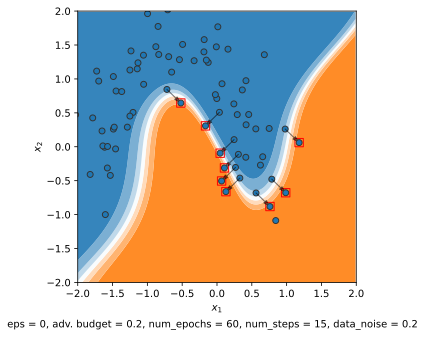

amount corr 70
amount wrong 1
amount succ attacks 6


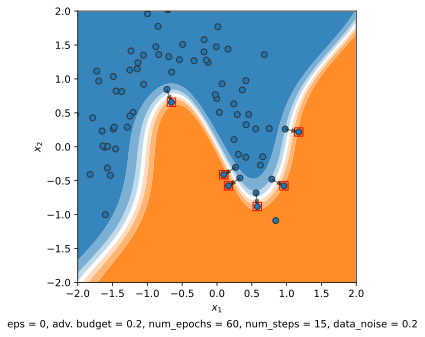

amount corr 69
amount wrong 2
amount succ attacks 5


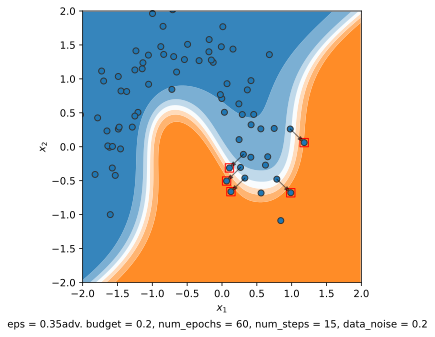

amount corr 69
amount wrong 2
amount succ attacks 4


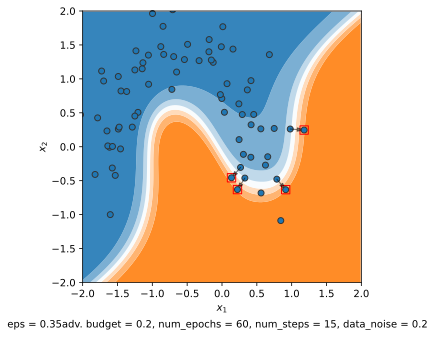

In [80]:
from plots.plots import visualize_classification
X_viz = X_viz[y_viz == 0]
y_viz = y_viz[y_viz == 0]
adversarial_budget = 0.2
footnote = f'adv. budget = {adversarial_budget}, {num_epochs = }, {num_steps = }, {data_noise = }'

visualize_classification(anode, X_viz, y_viz, footnote = 'eps = 0, ' + footnote)
X_attacks_base, y_attacks, grad = find_attacks(anode, X_viz, y_viz, adversarial_budget)
viz_attack(X_attacks_base, y_attacks, grad)
plt.savefig('moon_attack_fgsm.png', bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
plt.show()

visualize_classification(anode, X_viz, y_viz, footnote = 'eps = 0, ' + footnote)
X_attacks_base, y_attacks, grad = find_attacks(anode, X_viz, y_viz, adversarial_budget, attack_type = 'l2')
viz_attack(X_attacks_base, y_attacks, grad)
plt.savefig('moon_attack_l2.png', bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
plt.show()

visualize_classification(rnode, X_viz, y_viz, footnote = f'{eps = }, ' + footnote)
X_attacks_base, y_attacks, grad = find_attacks(rnode, X_viz, y_viz, adversarial_budget)
viz_attack(X_attacks_base, y_attacks, grad)
plt.savefig('moon_rob_attack_fgsm.png', bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
plt.show()

visualize_classification(rnode, X_viz, y_viz, footnote = f'{eps = }' + footnote)
X_attacks_base, y_attacks, grad = find_attacks(rnode, X_viz, y_viz, adversarial_budget, attack_type = 'l2')
viz_attack(X_attacks_base, y_attacks, grad)
plt.savefig('moon_rob_attack_l2.png', bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
plt.show()
# visualize_classification(rnode, X_viz[y_viz == 0], y_viz[y_viz == 0])
# viz_attack(data_0_attacks_base, grad_0)

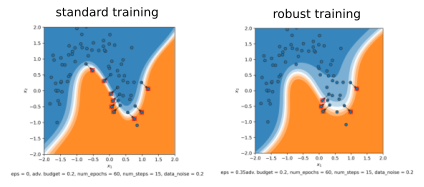

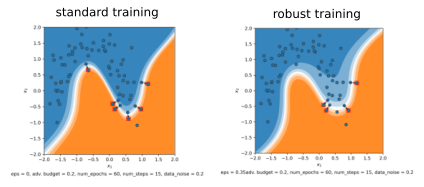

In [84]:
from plots.plots import comparison_plot
comparison_plot('moon_attack_fgsm.png', 'standard training', 'moon_rob_attack_fgsm.png', 'robust training', 'moon_fgsm_comp', show = True)
comparison_plot('moon_attack_l2.png', 'standard training', 'moon_rob_attack_l2.png', 'robust training', 'moon_l2_comp', show = True)

TypeError: viz_attack() missing 1 required positional argument: 'grad'

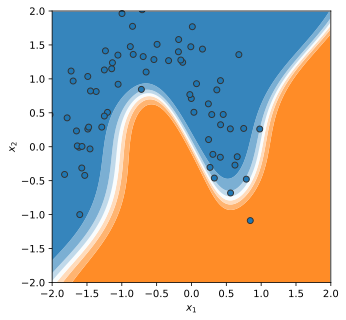

In [16]:
from plots.plots import visualize_classification
visualize_classification(anode, X_viz[y_viz == 0], y_viz[y_viz == 0])
viz_attack(data_0_attacks_base, grad_0)

visualize_classification(rnode, X_viz[y_viz == 0], y_viz[y_viz == 0])
viz_attack(data_0_attacks_base, grad_0)

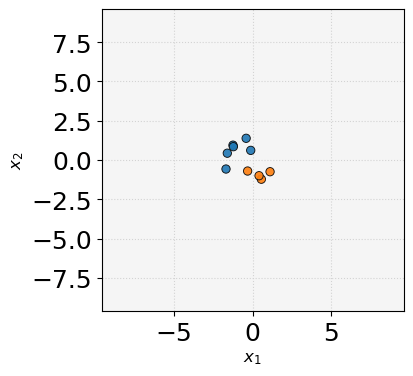

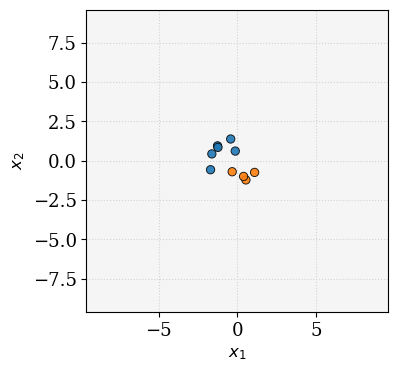

In [82]:
from plots.gifs import trajectory_gif

#the function trajectory_gif creates the evolution trajectories of the input data through the network
#the passing time corresponds to the depth of the network

for X_viz, y_viz in dataloader_viz:
    trajectory_gif(anode, X_viz[0:10], y_viz[0:10], timesteps=num_steps, filename = 'trajectory.gif', axlim = 8, dpi = 100)
    trajectory_gif(rnode, X_viz[0:10], y_viz[0:10], timesteps=num_steps, filename = 'trajectory_db.gif', axlim = 8, dpi = 100)
    break

#Display of the generated gif
traj = Image(filename="trajectory.gif", retina = True)
rtraj = Image(filename="trajectory_db.gif", retina = True)
display(traj, rtraj)

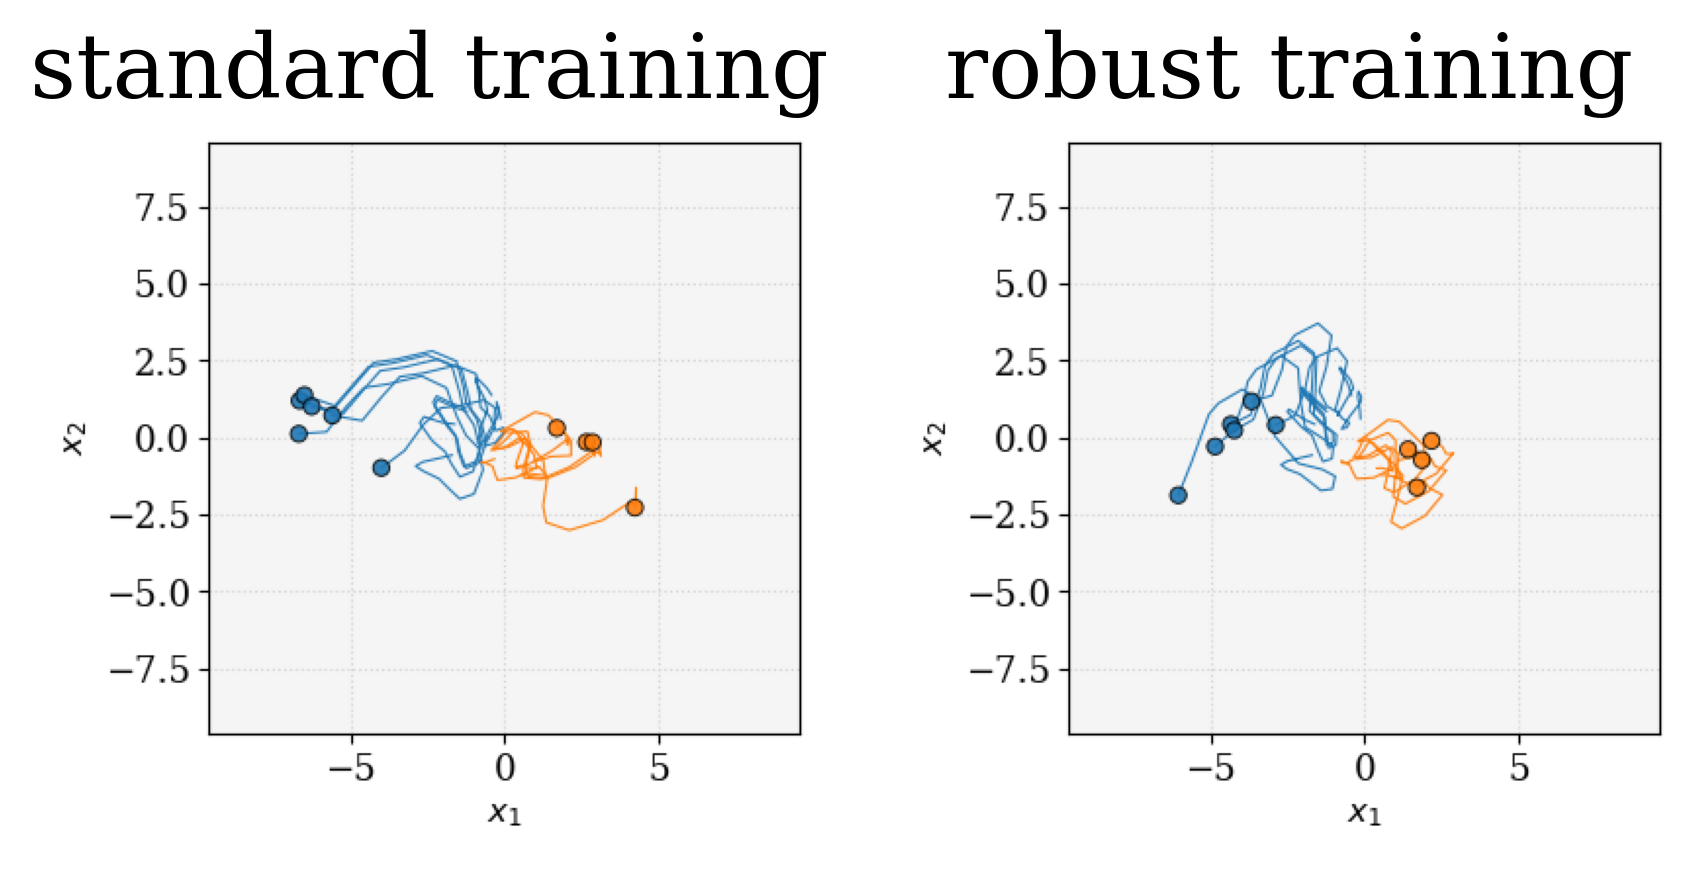

In [83]:
from IPython.display import Image
from plots.plots import comparison_plot
# traj = Image(filename="trajectory19.png", retina = True)
# rtraj = Image(filename="trajectory_db19.png", retina = True)
# display(traj, rtraj)

comparison_plot("trajectory19.png", 'standard training', "trajectory_db19.png", 'robust training', 'traj_comp.png')
display(Image('traj_comp.png', width = 800))

torch.Size([20])
torch.Size([20, 2])
tensor([[ 0.0000, -3.0000],
        [ 0.0000, -2.6842],
        [ 0.0000, -2.3684],
        [ 0.0000, -2.0526],
        [ 0.0000, -1.7368],
        [ 0.0000, -1.4211],
        [ 0.0000, -1.1053],
        [ 0.0000, -0.7895],
        [ 0.0000, -0.4737],
        [ 0.0000, -0.1579],
        [ 0.0000,  0.1579],
        [ 0.0000,  0.4737],
        [ 0.0000,  0.7895],
        [ 0.0000,  1.1053],
        [ 0.0000,  1.4211],
        [ 0.0000,  1.7368],
        [ 0.0000,  2.0526],
        [ 0.0000,  2.3684],
        [ 0.0000,  2.6842],
        [ 0.0000,  3.0000]])


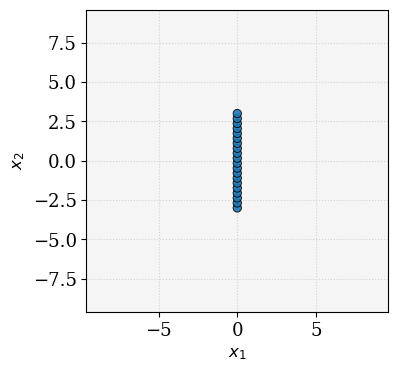

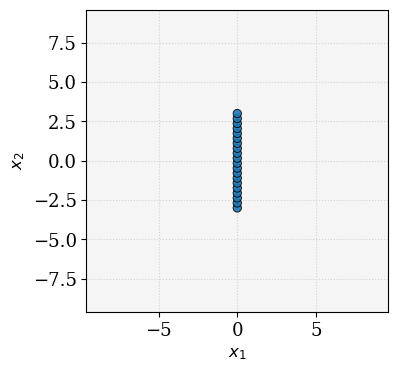

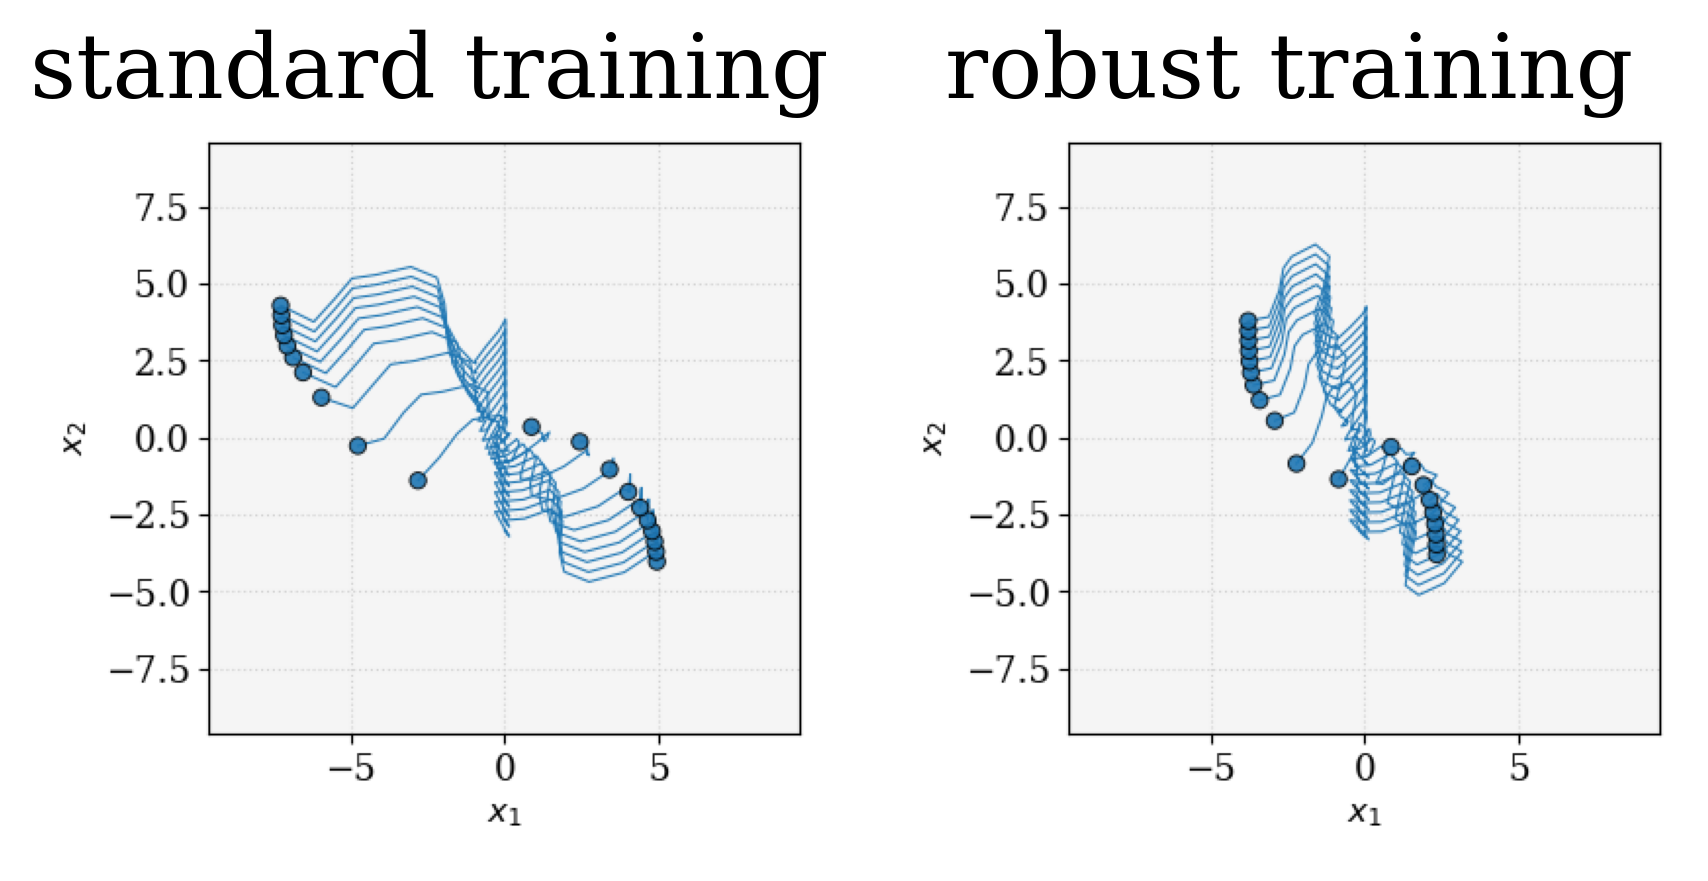

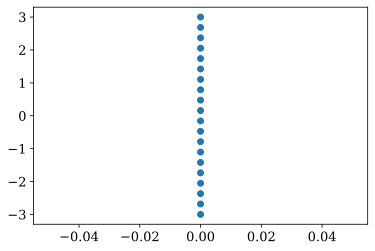

In [84]:
from plots.gifs import trajectory_gif

#the function trajectory_gif creates the evolution trajectories of the input data through the network
#the passing time corresponds to the depth of the network

data_iter = iter(dataloader)
X,y = next(data_iter)
batch_size = 20

X_viz = torch.zeros_like(X[0:batch_size])
y_viz = torch.zeros(batch_size)
print(y_viz.size())
print(X_viz.size())
X_viz[:,1] = torch.linspace(-3,3,batch_size)
X_viz[:,0] = torch.tensor([0])
print(X_viz)

plt.scatter(X_viz[:,0],X_viz[:,1])


trajectory_gif(anode, X_viz[0:batch_size], y_viz[0:batch_size], timesteps=num_steps, filename = 'trajectory.gif', axlim = 8, dpi = 100)
trajectory_gif(rnode, X_viz[0:batch_size], y_viz[0:batch_size], timesteps=num_steps, filename = 'trajectory_db.gif', axlim = 8, dpi = 100)
# break

# #Display of the generated gif
traj = Image(filename="trajectory.gif")
rtraj = Image(filename="trajectory_db.gif")
display(traj, rtraj)

comparison_plot("trajectory19.png", 'standard training', "trajectory_db19.png", 'robust training', 'traj_comp.png')
display(Image('traj_comp.png', width = 800))

I want to visualize the separation boundary in the final linear layer.

In [85]:
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import torch
import torch.nn as nn
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
from matplotlib.colors import to_rgb
import imageio

from matplotlib.colors import LinearSegmentedColormap
import os


@torch.no_grad()
def linlayer_levelsets(model, fig_name=None, footnote=None, contour = True, plotlim = [-2, 2]):
    
    
    x1lower, x1upper = plotlim
    x2lower, x2upper = plotlim

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    fig = plt.figure(figsize=(5, 5), dpi=100)
    
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.figtext(0.5, 0, footnote, ha="center", fontsize=10)

    
   
    model.to(device)

    x1 = torch.arange(x1lower, x1upper, step=0.01, device=device)
    x2 = torch.arange(x2lower, x2upper, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2)  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    
    preds = model.linear_layer(model_inputs)
    
    # dim = 2 means that it normalizes along the last dimension, i.e. along the two predictions that are the model output
    m = nn.Softmax(dim=2)
    # softmax normalizes the model predictions to probabilities
    preds = m(preds)

    #we only need the probability for being in class1 (as prob for class2 is then 1- class1)
    preds = preds[:, :, 0]
    preds = preds.unsqueeze(2)  # adds a tensor dimension at position 2
    
    plt.grid(False)
    plt.xlim([x1lower, x1upper])
    plt.ylim([x2lower, x2upper])

    ax = plt.gca()
    ax.set_aspect('equal') 
    
    if contour:
        colors = [to_rgb("C1"), [1, 1, 1], to_rgb("C0")] # first color is orange, last is blue
        cm = LinearSegmentedColormap.from_list(
            "Custom", colors, N=40)
        z = np.array(preds).reshape(xx1.shape)
        
        levels = np.linspace(0.,1.,20).tolist()
        
        cont = plt.contourf(xx1, xx2, z, levels, alpha=1, cmap=cm, zorder = 0, extent=(x1lower, x1upper, x2lower, x2upper)) #plt.get_cmap('coolwarm')
        cbar = fig.colorbar(cont, fraction=0.046, pad=0.04)
        cbar.ax.set_ylabel('prediction prob.')
    

    if fig_name:
        plt.savefig(fig_name + '.png', bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
        plt.clf()
        plt.close()
    # else: plt.show()
        

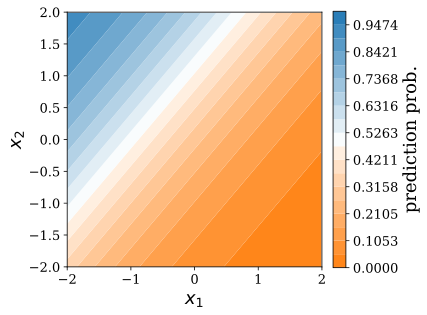

In [86]:
linlayer_levelsets(anode)

In [87]:
@torch.no_grad()
def trajectory_gif_new(model, inputs, targets, timesteps, dpi=200, alpha=0.9,
                   alpha_line=1, filename='trajectory.gif', axlim = 0):
    
    from matplotlib import rc
    from scipy.interpolate import interp1d
    rc("text", usetex = False)
    font = {'size'   : 18}
    rc('font', **font)

    if not filename.endswith(".gif"):
        raise RuntimeError("Name must end in with .gif, but ends with {}".format(filename))
    base_filename = filename[:-4]

    ## We focus on 3 colors at most
    if False in (t < 2 for t in targets): 
        color = ['mediumpurple' if targets[i] == 2.0 else 'gold' if targets[i] == 0.0 else 'mediumseagreen' for i in range(len(targets))]
    else:
        #color = ['crimson' if targets[i, 0] > 0.0 else 'dodgerblue' for i in range(len(targets))]
        color = ['C1' if targets[i] > 0.0 else 'dimgrey' for i in range(len(targets))]

    trajectories = model.flow.trajectory(inputs, timesteps).detach()
    num_dims = trajectories.shape[2]

    if axlim == 0:        
        x_min, x_max = trajectories[:, :, 0].min(), trajectories[:, :, 0].max()
        y_min, y_max = trajectories[:, :, 1].min(), trajectories[:, :, 1].max()
    else: 
        x_min, x_max = -axlim, axlim  #to normalize for rob and standard nODE
        y_min, y_max = -axlim, axlim   #
        
    if num_dims == 3:
        z_min, z_max = trajectories[:, :, 2].min(), trajectories[:, :, 2].max()
    margin = 0.1
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_min -= margin * x_range
    x_max += margin * x_range
    y_min -= margin * y_range
    y_max += margin * y_range
    if num_dims == 3:
        z_range = z_max - z_min
        z_min -= margin * z_range
        z_max += margin * z_range
        
    T = model.T 
    integration_time = torch.linspace(0.0, T, timesteps)
    
    interp_x = []
    interp_y = []
    interp_z = []
    for i in range(inputs.shape[0]):
        interp_x.append(interp1d(integration_time, trajectories[:, i, 0], kind='cubic', fill_value='extrapolate'))
        interp_y.append(interp1d(integration_time, trajectories[:, i, 1], kind='cubic', fill_value='extrapolate'))
        if num_dims == 3:
            interp_z.append(interp1d(integration_time, trajectories[:, i, 2], kind='cubic', fill_value='extrapolate'))
    
    interp_time = 20
    # interp_time = 3 #this was 5 before
    _time = torch.linspace(0., T, interp_time)

    plt.rc('grid', linestyle="dotted", color='lightgray')
    for t in range(interp_time):
        if num_dims == 2:
            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1)
            label_size = 13
            plt.rcParams['xtick.labelsize'] = label_size
            plt.rcParams['ytick.labelsize'] = label_size 
            ax.set_axisbelow(True)
            ax.xaxis.grid(color='lightgray', linestyle='dotted')
            ax.yaxis.grid(color='lightgray', linestyle='dotted')
            ax.set_facecolor('whitesmoke')
            
            plt.xlim(x_min, x_max)
            plt.ylim(y_min, y_max)
            plt.rc('text', usetex=False)
            plt.rc('font', family='serif')
            plt.xlabel(r'$x_1$', fontsize=12)
            plt.ylabel(r'$x_2$', fontsize=12)
            
            x1 = torch.arange(x_min, x_max, step=0.01, device=device)
            x2 = torch.arange(y_min, y_max, step=0.01, device=device)
            xx1, xx2 = torch.meshgrid(x1, x2)  # Meshgrid function as in numpy
            model_inputs = torch.stack([xx1, xx2], dim=-1)
            
            preds = model.linear_layer(model_inputs)
            
            # dim = 2 means that it normalizes along the last dimension, i.e. along the two predictions that are the model output
            m = nn.Softmax(dim=2)
            # softmax normalizes the model predictions to probabilities
            preds = m(preds)

            #we only need the probability for being in class1 (as prob for class2 is then 1- class1)
            preds = preds[:, :, 0]
            preds = preds.unsqueeze(2)  # adds a tensor dimension at position 2
            
            plt.grid(False)
    

            ax = plt.gca()
            ax.set_aspect('equal') 
            
            
            colors = [to_rgb("C1"), [1, 1, 1], to_rgb("C0")] # first color is orange, last is blue
            cm = LinearSegmentedColormap.from_list(
                "Custom", colors, N=40)
            z = np.array(preds).reshape(xx1.shape)
            
            levels = np.linspace(0.,1.,15).tolist()
            
            cont = plt.contourf(xx1, xx2, z, levels, alpha=0.5, cmap=cm, zorder = 0, extent=(x_min, x_max, y_min, y_max)) #plt.get_cmap('coolwarm')
            
            
            
            
            plt.scatter([x(_time)[t] for x in interp_x], 
                         [y(_time)[t] for y in interp_y], 
                         c=color, alpha=alpha, marker = 'o', linewidth=0.65, edgecolors='black', zorder=3)

            if t > 0:
                for i in range(inputs.shape[0]):
                    x_traj = interp_x[i](_time)[:t+1]
                    y_traj = interp_y[i](_time)[:t+1]
                    plt.plot(x_traj, y_traj, c=color[i], alpha=alpha_line, linewidth = 0.75, zorder=1)
            
        
        ax.set_aspect('equal')

        plt.savefig(base_filename + "{}.png".format(t),
                    format='png', dpi=dpi, bbox_inches='tight', facecolor = 'white')
        # Save only 3 frames (.pdf for paper)
        # if t in [0, interp_time//5, interp_time//2, interp_time-1]:
        #     plt.savefig(base_filename + "{}.pdf".format(t), format='pdf', bbox_inches='tight')
        plt.clf()
        plt.close()

    imgs = []
    for i in range(interp_time):
        img_file = base_filename + "{}.png".format(i)
        imgs.append(imageio.imread(img_file))
        if i not in [0, interp_time//5, interp_time//2, interp_time-1]: os.remove(img_file) 
    imageio.mimwrite(filename, imgs, fps = 2)

In [88]:
trajectory_gif_new(anode, X_viz[0:batch_size], y_viz[0:batch_size], timesteps=num_steps, filename = 'trajectory.gif', axlim = 8, dpi = 100)
trajectory_gif_new(rnode, X_viz[0:batch_size], y_viz[0:batch_size], timesteps=num_steps, filename = 'trajectory_db.gif', axlim = 8, dpi = 100)


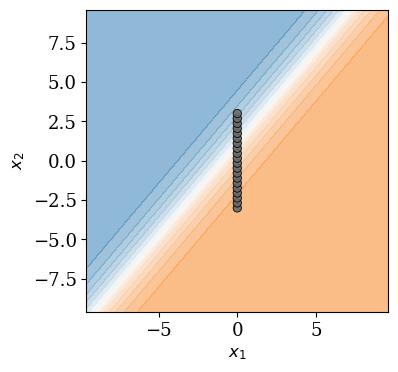

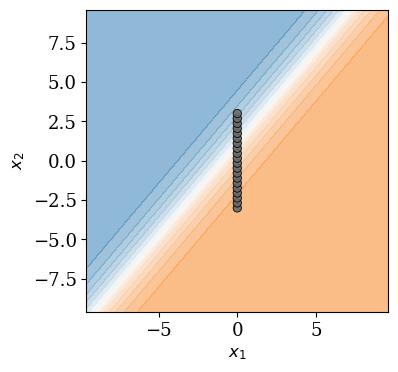

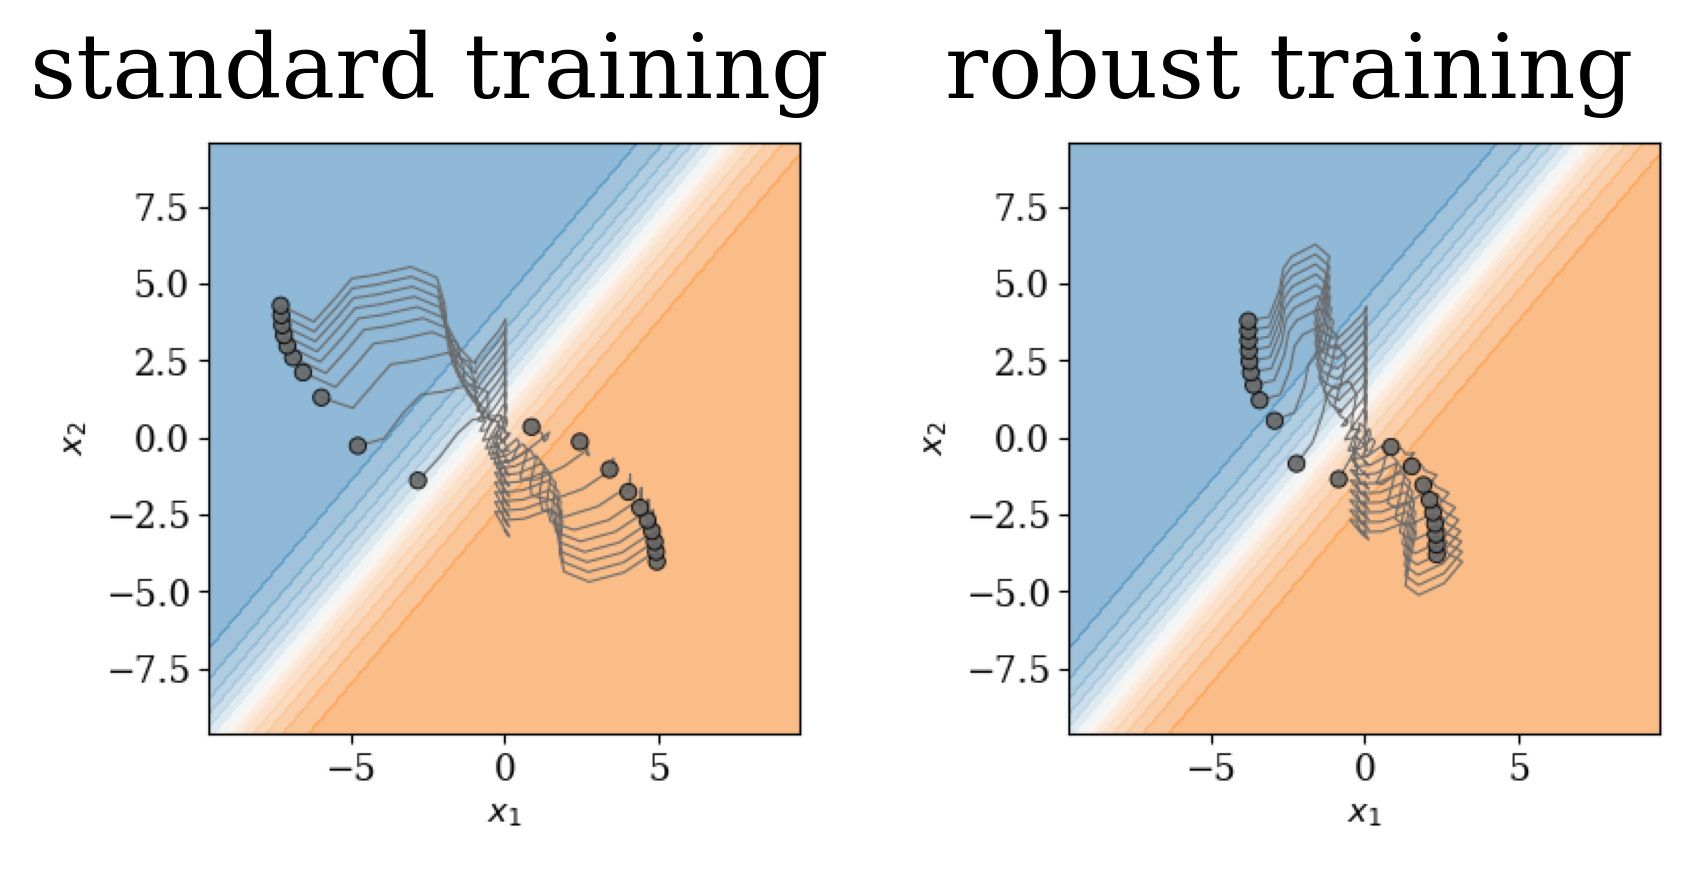

In [89]:
traj = Image(filename="trajectory.gif")
rtraj = Image(filename="trajectory_db.gif")
display(traj, rtraj)

comparison_plot("trajectory19.png", 'standard training', "trajectory_db19.png", 'robust training', 'traj_comp.png')
display(Image('traj_comp.png', width = 800))